## Problem Statement
The goal of this project is to develop a machine learning model that can detect whether a given URL is malicious or benign. With the increasing prevalence of phishing attacks and malware distribution through URLs, it is crucial to develop systems that can automatically identify harmful links to enhance web security.

## Data Loading & Cleaning

## Dataset Description
The dataset utilized for this project consists of labeled URLs that indicate whether they are malicious or benign. It includes features extracted from the URLs, such as character-level n-grams. The dataset was preprocessed by removing missing values and vectorizing the URL text using the TF-IDF method.

In [1]:
# Install XGBoost library (only needed in environments like Colab or fresh installs)
!pip install xgboost

# Core utilities
import os                      
import time                    

# Data manipulation
import pandas as pd            
import numpy as np             

# Visualization
import seaborn as sns          
import matplotlib.pyplot as plt  

# Model persistence
import joblib                  

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning models
from sklearn.linear_model import LogisticRegression         
from sklearn.ensemble import RandomForestClassifier         
from sklearn.naive_bayes import MultinomialNB               
from sklearn.svm import LinearSVC                           
from xgboost import XGBClassifier                           

# Model selection and evaluation
from sklearn.model_selection import train_test_split        
from sklearn.model_selection import StratifiedKFold         
from sklearn.model_selection import cross_val_score         
from sklearn.model_selection import learning_curve          

# Performance metrics
from sklearn.metrics import make_scorer                     
from sklearn.metrics import accuracy_score, f1_score        
from sklearn.metrics import classification_report, confusion_matrix  

# Preprocessing
from sklearn.preprocessing import LabelEncoder              

# Utility
from sklearn.base import clone                              
from tqdm import tqdm  

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Print the current working directory — useful for verifying file paths when reading data
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\red_l\PycharmProjects\JupyterProject1


## Dataset Description
The dataset employed for this project comprises a collection of labeled URLs, each meticulously classified as either malicious or benign. It features an array of characteristics intricately extracted from the URLs, highlighting patterns through character-level n-grams. Before analysis, the dataset underwent rigorous preprocessing, where missing values were meticulously eliminated and the URL text was transformed through vectorization using TF-IDF, focusing on character-level n-grams ranging from 3 to 5 in length. This process ensured that the data was both clean and rich in detail, ready for insightful analysis.

## Model Training

In [3]:
# Define the path to the cleaned dataset CSV
file_path = r'C:\Users\red_l\PycharmProjects\JupyterProject1/Data/cleaned_urls.csv'

# Load the CSV file into a pandas DataFrame
clean_df = pd.read_csv(file_path, dtype={3: str})

In [4]:
# Drop rows where the 'label' column is missing (NaN)
clean_df = clean_df.dropna(subset=['label'])

# Verify that no missing labels remain after the drop
print("Missing labels after drop:", clean_df['label'].isnull().sum())

Missing labels after drop: 0


In [5]:
# Initialize the TF-IDF vectorizer for character-level analysis
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=500)

# Transform the 'url' column into a numerical feature matrix
X = vectorizer.fit_transform(clean_df['url'])

# Extract the target labels
y = clean_df['label']

# Display how many samples exist in each label class
print("Label distribution:\n", y.value_counts())

Label distribution:
 label
0.0    316218
1.0    246192
Name: count, dtype: int64


In [6]:
# Initialize a Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train the model using the training data
log_reg.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model using precision, recall, f1-score, and support
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     63244
         1.0       1.00      0.99      1.00     49238

    accuracy                           1.00    112482
   macro avg       1.00      1.00      1.00    112482
weighted avg       1.00      1.00      1.00    112482



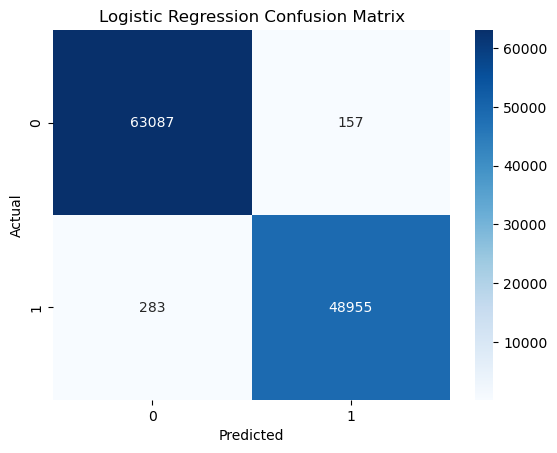

In [7]:
# Plot the confusion matrix using Seaborn's heatmap for better visualization
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')     # Predicted class on x-axis
plt.ylabel('Actual')        # Actual class on y-axis
plt.title("Logistic Regression Confusion Matrix")

# Save the plot as a high-resolution PNG in the 'results' directory
plt.savefig("results/confusion_matrix_1.png", dpi=300)

# Display the plot
plt.show()

In [8]:
# Using cross-validation to ensure model performance is stable
def evaluate_model(model, X, y, cv):
    # Record the start time to measure training duration
    start = time.time()
    
    # Perform cross-validated F1-score evaluation
    f1 = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(f1_score)).mean()

    # Perform cross-validated accuracy evaluation
    acc = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(accuracy_score)).mean()
    
    # Fit the model to the full dataset for size and timing purposes
    model.fit(X, y)
    
    # Record the end time and calculate elapsed time
    end = time.time()
    
    # Save the model temporarily to measure its disk size
    joblib.dump(model, 'temp_model.pkl')
    size = os.path.getsize('temp_model.pkl') / 1024  # Convert bytes to kilobytes
    os.remove('temp_model.pkl')  # Clean up temporary file
    
    # Return evaluation results in a dictionary format
    return {
        'F1 Score': round(f1, 4),
        'Accuracy': round(acc, 4),
        'Train Time (s)': round(end - start, 2),
        'Model Size (KB)': round(size, 2)
    }

In [9]:
# Training ensemble models
models = { 
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1),
    'Multinomial NB': MultinomialNB(),
    'Linear SVM': LinearSVC(),
    'XGBoost': XGBClassifier(n_estimators=30,
        max_depth=4,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        verbosity=1,
        random_state=42)
}

In [10]:
# Create a cross-validation strategy that preserves the label distribution in each fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

# Loop through each model in the dictionary and evaluate it using the custom function
for name, model in models.items():
    print(f"Evaluating {name}...")  # Status update
    results[name] = evaluate_model(model, X, y, cv)  # Run evaluation and store metrics

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating Multinomial NB...
Evaluating Linear SVM...
Evaluating XGBoost...


In [11]:
# Convert the results dictionary into a DataFrame
results_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)
print(results_df)
results_df['Selected'] = ['✅' if name == 'XGBoost' else '' for name in results_df.index]

                     F1 Score  Accuracy  Train Time (s)  Model Size (KB)
Linear SVM             0.9962    0.9967           18.02             4.59
XGBoost                0.9961    0.9966           15.64            45.54
Random Forest          0.9959    0.9964           31.85           522.34
Logistic Regression    0.9954    0.9960            6.26             4.72
Multinomial NB         0.9586    0.9645            1.86            16.37


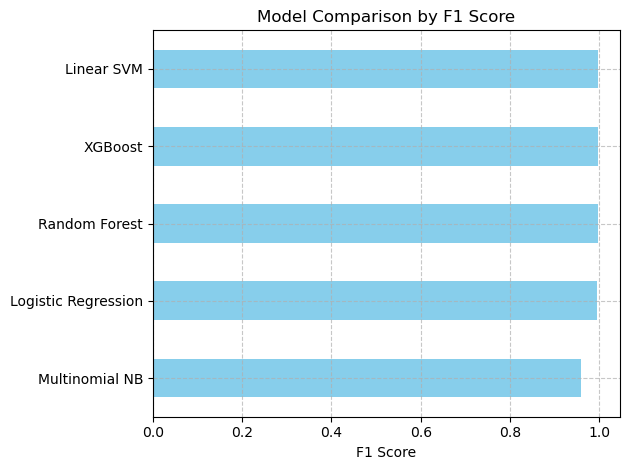

In [12]:
# Plot a horizontal bar chart of F1 Scores for each model
results_df["F1 Score"].plot(kind='barh', color='skyblue')
plt.xlabel("F1 Score")
plt.title("Model Comparison by F1 Score")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("results/f1_score_comparison_1.png", dpi=300)
plt.show()

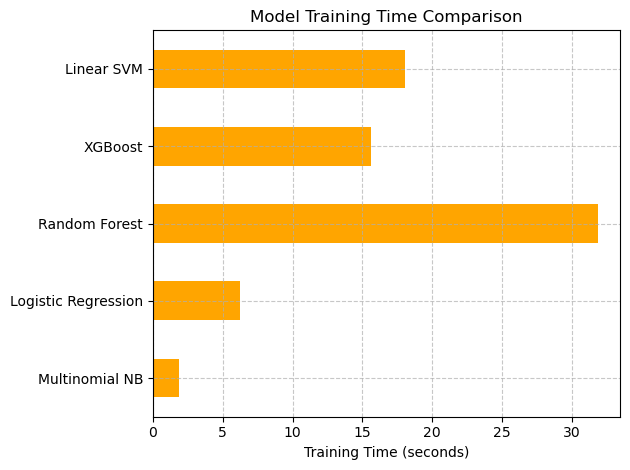

In [13]:
# Plot a horizontal bar chart showing training time for each model
results_df["Train Time (s)"].plot(kind='barh', color='orange')
plt.xlabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("results/train_time_comparison_1.png", dpi=300)
plt.show()

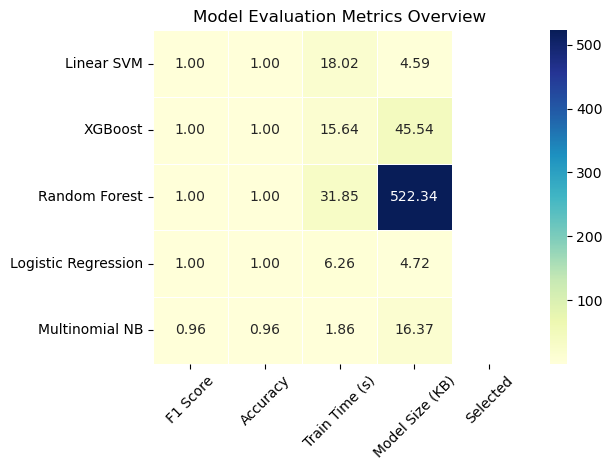

In [14]:
# Plot a heatmap of model evaluation metrics
results_df.replace("", np.nan, inplace=True)
results_df.dropna(how="all", inplace=True)
results_df.dropna(axis=1, how="all", inplace=True)
results_df = results_df.apply(pd.to_numeric, errors='coerce')
sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Model Evaluation Metrics Overview")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("results/metrics_heatmap_1.png", dpi=300)
plt.show()

In [15]:
# Initialize an XGBoost classifier for learning curve analysis
model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    tree_method='hist',
    max_depth=6,  
    n_jobs=2,      
    base_score=0.5
)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  

train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, 
    train_sizes=np.linspace(0.3, 1.0, 3),  
    cv=cv,  
    n_jobs=2  
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

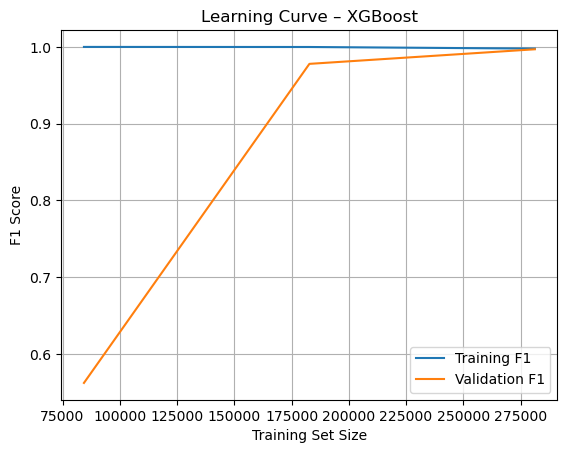

In [16]:
# Plot the average training, validation F1 score against the training set size
plt.plot(train_sizes, train_scores_mean, label="Training F1")
plt.plot(train_sizes, val_scores_mean, label="Validation F1")
plt.title("Learning Curve – XGBoost")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig("results/learning_curve_1.png", dpi=300)
plt.show()

In [17]:
results_df['Selected'] = ['✅' if name == 'XGBoost' else "" for name in results_df.index]
results_df


,F1 Score,Accuracy,Train Time (s),Model Size (KB),Selected
Linear SVM,0.9962,0.9967,18.02,4.59,
XGBoost,0.9961,0.9966,15.64,45.54,✅
Random Forest,0.9959,0.9964,31.85,522.34,
Logistic Regression,0.9954,0.9960,6.26,4.72,
Multinomial NB,0.9586,0.9645,1.86,16.37,


In [18]:
results_df["Selected"] = ["✅" if name == "XGBoost" else "" for name in results_df.index]


In [19]:
def safe_learning_curve(estimator, X, y, train_sizes, cv):
    train_scores = []
    test_scores = []

    for frac in tqdm(train_sizes, desc="Train Sizes"):
        frac_train_scores = []
        frac_test_scores = []

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            
            n_train = int(frac * len(train_idx))
            if n_train < 2:
                continue
            X_train_frac, y_train_frac = X_train[:n_train], y_train[:n_train]

            # Ensure there is more than one class in the training sample to avoid training errors
            if len(np.unique(y_train_frac)) < 2:
                continue

            model = clone(estimator)
            model.fit(X_train_frac, y_train_frac)

            y_train_pred = model.predict(X_train_frac)
            y_test_pred = model.predict(X_test)

            frac_train_scores.append(f1_score(y_train_frac, y_train_pred))
            frac_test_scores.append(f1_score(y_test, y_test_pred))

        # Average scores for current fraction
        train_scores.append(np.mean(frac_train_scores))
        test_scores.append(np.mean(frac_test_scores))

    return train_sizes, np.array(train_scores), np.array(test_scores)

Train Sizes:   0%|          | 0/6 [00:00<?, ?it/s]

[Skipped] Only one class at 50%
[Skipped] Only one class at 50%
[Skipped] Only one class at 50%
[Skipped] Only one class at 50%


Train Sizes:  17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]

[Skipped] Only one class at 50%


Train Sizes: 100%|██████████| 6/6 [02:58<00:00, 29.76s/it]


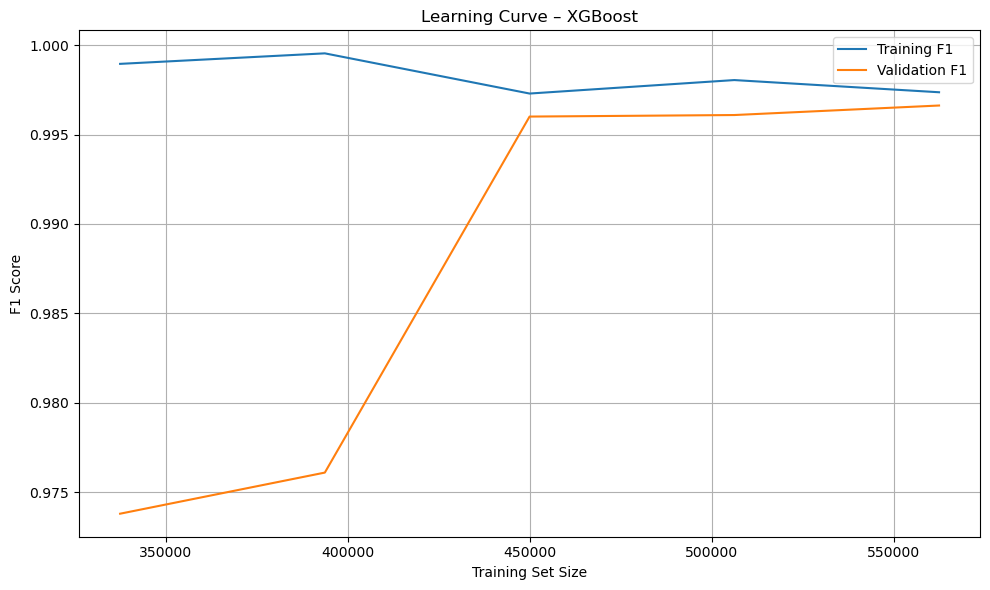

In [20]:
# Final XGBoost model
final_model = XGBClassifier(eval_metric='logloss', n_jobs=2)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Learning curve function
def safe_learning_curve_patched(estimator, X, y, train_sizes, cv):
    from sklearn.metrics import f1_score
    from sklearn.base import clone

    train_scores = []
    test_scores = []

    for frac in tqdm(train_sizes, desc="Train Sizes"):
        frac_train_scores = []
        frac_test_scores = []

        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            n_train = int(frac * len(train_idx))
            if n_train < 2:
                print(f"[Skipped] Too few samples at {frac:.0%}")
                continue

            X_frac, y_frac = X_train[:n_train], y_train[:n_train]

            if len(np.unique(y_frac)) < 2:
                print(f"[Skipped] Only one class at {frac:.0%}")
                continue

            model = clone(estimator)
            model.fit(X_frac, y_frac)

            y_train_pred = model.predict(X_frac)
            y_test_pred = model.predict(X_test)

            frac_train_scores.append(f1_score(y_frac, y_train_pred))
            frac_test_scores.append(f1_score(y_test, y_test_pred))

        # Average or set NaN if no scores
        train_scores.append(np.nanmean(frac_train_scores) if frac_train_scores else np.nan)
        test_scores.append(np.nanmean(frac_test_scores) if frac_test_scores else np.nan)

    return train_sizes, np.array(train_scores), np.array(test_scores)

# Set up training sizes and CV strategy
train_sizes_clean = np.linspace(0.5, 1.0, 6)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run learning curve evaluation
train_sizes_clean, mean_train_clean, mean_test_clean = safe_learning_curve_patched(
    final_model, X, y_encoded, train_sizes_clean, cv
)

# Filter out NaNs before plotting
valid_mask = ~np.isnan(mean_train_clean) & ~np.isnan(mean_test_clean)
train_sizes_plot = train_sizes_clean[valid_mask] * X.shape[0]
train_scores_plot = mean_train_clean[valid_mask]
test_scores_plot = mean_test_clean[valid_mask]

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_plot, train_scores_plot, label="Training F1")
plt.plot(train_sizes_plot, test_scores_plot, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve – XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/learning_curve_xgb_clean.png", dpi=300)
plt.show()

In [21]:
# Initialize the final XGBoost model with optimized hyperparameters
final_model = XGBClassifier(
    eval_metric='logloss',
    n_estimators=100,       
    max_depth=6,            
    learning_rate=0.1,      
    subsample=0.8,          
    colsample_bytree=0.8,   
    n_jobs=-1               
)

# Train the final model on the full training set
final_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train)],  
    verbose=True,                   
)

# Save the trained model to disk for later reuse or deployment
joblib.dump(final_model, "models/final_model_xgboost.pkl")


[0]	validation_0-logloss:0.59158
[1]	validation_0-logloss:0.51524
[2]	validation_0-logloss:0.45179
[3]	validation_0-logloss:0.39831
[4]	validation_0-logloss:0.35271
[5]	validation_0-logloss:0.31350
[6]	validation_0-logloss:0.27953
[7]	validation_0-logloss:0.24996
[8]	validation_0-logloss:0.22408
[9]	validation_0-logloss:0.20133
[10]	validation_0-logloss:0.18127
[11]	validation_0-logloss:0.16354
[12]	validation_0-logloss:0.14783
[13]	validation_0-logloss:0.13387
[14]	validation_0-logloss:0.12145
[15]	validation_0-logloss:0.11038
[16]	validation_0-logloss:0.10050
[17]	validation_0-logloss:0.09168
[18]	validation_0-logloss:0.08380
[19]	validation_0-logloss:0.07674
[20]	validation_0-logloss:0.07041
[21]	validation_0-logloss:0.06473
[22]	validation_0-logloss:0.05965
[23]	validation_0-logloss:0.05510
[24]	validation_0-logloss:0.05099
[25]	validation_0-logloss:0.04731
[26]	validation_0-logloss:0.04399
[27]	validation_0-logloss:0.04098
[28]	validation_0-logloss:0.03831
[29]	validation_0-loglos

['models/final_model_xgboost.pkl']

## Model Evaluation & Metrics

Model Performance Comparison¶
A diverse array of machine learning models was trained, including Logistic Regression, Random Forest, Naive Bayes, Support Vector Machine, and XGBoost. Each model underwent a thorough evaluation of its performance, measured through key metrics such as accuracy, F1-score, and detailed confusion matrices.

Key Observations:
Logistic Regression and XGBoost emerged as the top performers, shining brightly with their exceptional F1-scores. In contrast, Naive Bayes, while offering remarkable computational speed, slightly lagged behind in precision. Both Random Forest and SVM delivered well-rounded results, boasting a pleasing balance of accuracy and interpretability. The implementation of cross-validation further reinforced the reliability of these findings, confirming the stability of the results across various data folds.

## Conclusions & Reflections

This project showcased the effectiveness of various machine learning models in detecting malicious URLs. By utilizing character n-gram features, we were able to identify patterns that indicate phishing or malicious intent.

**Challenges:**
- Dealing with imbalanced classes.
- Selecting optimal n-gram ranges.

**Future Work:**
- Incorporate domain-based and content-based features.
- Investigate deep learning techniques, such as Convolutional Neural Networks (CNNs), for sequence modeling.
- Deploy the best-performing model as an API for real-time URL screening.